# Method 5 - Best Ideas DGTW Selection

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best
    
best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)


monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - dgtw_cont).dropna()
monthly_return.name = 'port_return'

## Plot Performance

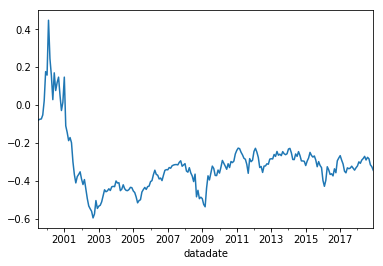

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.176060
2000-12-31   -0.137256
2001-12-31   -0.361912
2002-12-31   -0.298725
2003-12-31    0.253202
2004-12-31   -0.009230
2005-12-31    0.014616
2006-12-31    0.151961
2007-12-31    0.036974
2008-12-31   -0.248587
2009-12-31    0.279086
2010-12-31    0.129315
2011-12-31   -0.044100
2012-12-31    0.007784
2013-12-31    0.039522
2014-12-31   -0.053651
2015-12-31   -0.047258
2016-12-31    0.075533
2017-12-31   -0.071580
2018-12-31   -0.019682
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     71.29
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.90e-39
Time:                        04:10:34   Log-Likelihood:                 443.02
No. Observations:                 234   AIC:                            -876.0
Df Residuals:                     229   BIC:                            -858.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.003     -0.064      0.949      -0.005       0.005
mktrf          0.3426      0.069      4.987      0.000       0.207       0.478
me             0.4056      0.080      5.076      0.000       0.248       0.563
ia            -0.3839      0.121     -3.161      0.002      -0.623      -0.145
roe           -0.6450      0.104     -6.204      0.000      -0.850      -0.440
==============================================================================
Omnibus:                       34.680   Durbin-Watson:                   2.380
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              177.856
Skew:                           0.376   Prob(JB):                     2.39e-39
Kurtosis:                       7.204   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     41.67
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.16e-26
Time:                        04:10:34   Log-Likelihood:                 443.02
No. Observations:                 234   AIC:                            -876.0
Df Residuals:                     229   BIC:                            -858.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.002     -0.076      0.940      -0.004       0.004
mktrf          0.3426      0.084      4.095      0.000       0.179       0.507
me             0.4056      0.154      2.629      0.009       0.103       0.708
ia            -0.3839      0.177     -2.174      0.030      -0.730      -0.038
roe           -0.6450      0.145     -4.444      0.000      -0.929      -0.361
==============================================================================
Omnibus:                       34.680   Durbin-Watson:                   2.380
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              177.856
Skew:                           0.376   Prob(JB):                     2.39e-39
Kurtosis:                       7.204   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     64.41
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.02e-36
Time:                        04:10:34   Log-Likelihood:                 443.02
No. Observations:                 234   AIC:                            -876.0
Df Residuals:                     229   BIC:                            -858.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.002     -0.076      0.939      -0.004       0.004
mktrf          0.3426      0.084      4.087      0.000       0.178       0.507
me             0.4056      0.163      2.487      0.013       0.086       0.725
ia            -0.3839      0.164     -2.345      0.019      -0.705      -0.063
roe           -0.6450      0.139     -4.643      0.000      -0.917      -0.373
==============================================================================
Omnibus:                       34.680   Durbin-Watson:                   2.380
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              177.856
Skew:                           0.376   Prob(JB):                     2.39e-39
Kurtosis:                       7.204   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     64.28
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.20e-41
Time:                        04:10:34   Log-Likelihood:                 451.29
No. Observations:                 234   AIC:                            -890.6
Df Residuals:                     228   BIC:                            -869.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.213      0.831      -0.004       0.005
mktrf          0.3727      0.067      5.598      0.000       0.242       0.504
smb            0.3099      0.088      3.528      0.001       0.137       0.483
hml           -0.0961      0.104     -0.928      0.355      -0.300       0.108
rmw           -0.8163      0.117     -6.969      0.000      -1.047      -0.585
cma            0.0032      0.149      0.022      0.983      -0.290       0.297
==============================================================================
Omnibus:                       48.133   Durbin-Watson:                   2.294
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.429
Skew:                           0.706   Prob(JB):                     2.25e-48
Kurtosis:                       7.529   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     62.23
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.01e-40
Time:                        04:10:34   Log-Likelihood:                 451.29
No. Observations:                 234   AIC:                            -890.6
Df Residuals:                     228   BIC:                            -869.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.340      0.734      -0.002       0.004
mktrf          0.3727      0.057      6.526      0.000       0.261       0.485
smb            0.3099      0.095      3.265      0.001       0.124       0.496
hml           -0.0961      0.165     -0.582      0.560      -0.420       0.227
rmw           -0.8163      0.126     -6.464      0.000      -1.064      -0.569
cma            0.0032      0.174      0.018      0.985      -0.338       0.344
==============================================================================
Omnibus:                       48.133   Durbin-Watson:                   2.294
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.429
Skew:                           0.706   Prob(JB):                     2.25e-48
Kurtosis:                       7.529   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     99.58
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.46e-55
Time:                        04:10:34   Log-Likelihood:                 451.29
No. Observations:                 234   AIC:                            -890.6
Df Residuals:                     228   BIC:                            -869.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.378      0.705      -0.002       0.003
mktrf          0.3727      0.052      7.144      0.000       0.270       0.475
smb            0.3099      0.101      3.073      0.002       0.112       0.508
hml           -0.0961      0.146     -0.660      0.509      -0.381       0.189
rmw           -0.8163      0.121     -6.756      0.000      -1.053      -0.579
cma            0.0032      0.143      0.022      0.982      -0.277       0.284
==============================================================================
Omnibus:                       48.133   Durbin-Watson:                   2.294
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.429
Skew:                           0.706   Prob(JB):                     2.25e-48
Kurtosis:                       7.529   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     64.13
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.63e-36
Time:                        04:10:34   Log-Likelihood:                 436.31
No. Observations:                 234   AIC:                            -862.6
Df Residuals:                     229   BIC:                            -845.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.003     -1.119      0.264      -0.008       0.002
mktrf          0.4989      0.065      7.665      0.000       0.371       0.627
smb            0.6564      0.081      8.079      0.000       0.496       0.816
hml           -0.2935      0.081     -3.637      0.000      -0.453      -0.135
umd           -0.1727      0.053     -3.261      0.001      -0.277      -0.068
==============================================================================
Omnibus:                       28.529   Durbin-Watson:                   2.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.300
Skew:                           0.486   Prob(JB):                     2.22e-18
Kurtosis:                       5.719   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     35.77
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.29e-23
Time:                        04:10:34   Log-Likelihood:                 436.31
No. Observations:                 234   AIC:                            -862.6
Df Residuals:                     229   BIC:                            -845.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.002     -1.366      0.172      -0.007       0.001
mktrf          0.4989      0.067      7.422      0.000       0.367       0.631
smb            0.6564      0.131      5.007      0.000       0.399       0.913
hml           -0.2935      0.113     -2.608      0.009      -0.514      -0.073
umd           -0.1727      0.085     -2.026      0.043      -0.340      -0.006
==============================================================================
Omnibus:                       28.529   Durbin-Watson:                   2.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.300
Skew:                           0.486   Prob(JB):                     2.22e-18
Kurtosis:                       5.719   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     45.32
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.18e-28
Time:                        04:10:34   Log-Likelihood:                 436.31
No. Observations:                 234   AIC:                            -862.6
Df Residuals:                     229   BIC:                            -845.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.002     -1.370      0.171      -0.007       0.001
mktrf          0.4989      0.066      7.574      0.000       0.370       0.628
smb            0.6564      0.129      5.076      0.000       0.403       0.910
hml           -0.2935      0.106     -2.773      0.006      -0.501      -0.086
umd           -0.1727      0.081     -2.138      0.033      -0.331      -0.014
==============================================================================
Omnibus:                       28.529   Durbin-Watson:                   2.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.300
Skew:                           0.486   Prob(JB):                     2.22e-18
Kurtosis:                       5.719   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     36.47
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.16e-19
Time:                        04:10:34   Log-Likelihood:                 203.19
No. Observations:                 120   AIC:                            -396.4
Df Residuals:                     115   BIC:                            -382.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.004      0.117      0.907      -0.008       0.009
mktrf          0.3146      0.117      2.685      0.008       0.083       0.547
me             0.4337      0.116      3.748      0.000       0.205       0.663
ia            -0.5150      0.181     -2.842      0.005      -0.874      -0.156
roe           -0.6005      0.160     -3.744      0.000      -0.918      -0.283
==============================================================================
Omnibus:                       14.035   Durbin-Watson:                   2.424
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               34.912
Skew:                           0.340   Prob(JB):                     2.62e-08
Kurtosis:                       5.554   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     32.11
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.87e-18
Time:                        04:10:34   Log-Likelihood:                 203.19
No. Observations:                 120   AIC:                            -396.4
Df Residuals:                     115   BIC:                            -382.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.004      0.132      0.895      -0.007       0.008
mktrf          0.3146      0.129      2.437      0.015       0.062       0.568
me             0.4337      0.196      2.211      0.027       0.049       0.818
ia            -0.5150      0.242     -2.125      0.034      -0.990      -0.040
roe           -0.6005      0.210     -2.855      0.004      -1.013      -0.188
==============================================================================
Omnibus:                       14.035   Durbin-Watson:                   2.424
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               34.912
Skew:                           0.340   Prob(JB):                     2.62e-08
Kurtosis:                       5.554   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     47.63
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.47e-23
Time:                        04:10:34   Log-Likelihood:                 203.19
No. Observations:                 120   AIC:                            -396.4
Df Residuals:                     115   BIC:                            -382.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.004      0.130      0.897      -0.007       0.008
mktrf          0.3146      0.131      2.407      0.016       0.058       0.571
me             0.4337      0.210      2.063      0.039       0.022       0.846
ia            -0.5150      0.215     -2.400      0.016      -0.936      -0.094
roe           -0.6005      0.212     -2.839      0.005      -1.015      -0.186
==============================================================================
Omnibus:                       14.035   Durbin-Watson:                   2.424
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               34.912
Skew:                           0.340   Prob(JB):                     2.62e-08
Kurtosis:                       5.554   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     34.67
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.08e-21
Time:                        04:10:34   Log-Likelihood:                 209.51
No. Observations:                 120   AIC:                            -407.0
Df Residuals:                     114   BIC:                            -390.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.004      0.459      0.647      -0.006       0.010
mktrf          0.4217      0.118      3.582      0.001       0.188       0.655
smb            0.3654      0.133      2.740      0.007       0.101       0.630
hml           -0.3180      0.163     -1.946      0.054      -0.642       0.006
rmw           -0.6084      0.193     -3.158      0.002      -0.990      -0.227
cma            0.0638      0.211      0.302      0.763      -0.354       0.482
==============================================================================
Omnibus:                       23.869   Durbin-Watson:                   2.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.899
Skew:                           0.730   Prob(JB):                     1.62e-13
Kurtosis:                       6.106   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     54.02
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.69e-28
Time:                        04:10:34   Log-Likelihood:                 209.51
No. Observations:                 120   AIC:                            -407.0
Df Residuals:                     114   BIC:                            -390.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      0.788      0.431      -0.003       0.007
mktrf          0.4217      0.114      3.709      0.000       0.199       0.645
smb            0.3654      0.139      2.621      0.009       0.092       0.639
hml           -0.3180      0.181     -1.759      0.079      -0.672       0.036
rmw           -0.6084      0.190     -3.196      0.001      -0.982      -0.235
cma            0.0638      0.202      0.315      0.753      -0.333       0.460
==============================================================================
Omnibus:                       23.869   Durbin-Watson:                   2.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.899
Skew:                           0.730   Prob(JB):                     1.62e-13
Kurtosis:                       6.106   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     93.85
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.44e-39
Time:                        04:10:34   Log-Likelihood:                 209.51
No. Observations:                 120   AIC:                            -407.0
Df Residuals:                     114   BIC:                            -390.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      0.924      0.356      -0.002       0.006
mktrf          0.4217      0.103      4.092      0.000       0.220       0.624
smb            0.3654      0.147      2.480      0.013       0.077       0.654
hml           -0.3180      0.149     -2.135      0.033      -0.610      -0.026
rmw           -0.6084      0.191     -3.178      0.001      -0.984      -0.233
cma            0.0638      0.155      0.412      0.680      -0.239       0.367
==============================================================================
Omnibus:                       23.869   Durbin-Watson:                   2.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.899
Skew:                           0.730   Prob(JB):                     1.62e-13
Kurtosis:                       6.106   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     41.06
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.45e-21
Time:                        04:10:34   Log-Likelihood:                 207.27
No. Observations:                 120   AIC:                            -404.5
Df Residuals:                     115   BIC:                            -390.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.004     -0.259      0.796      -0.009       0.007
mktrf          0.5172      0.100      5.184      0.000       0.320       0.715
smb            0.6566      0.114      5.780      0.000       0.432       0.882
hml           -0.4436      0.114     -3.899      0.000      -0.669      -0.218
umd           -0.1524      0.070     -2.173      0.032      -0.291      -0.013
==============================================================================
Omnibus:                       15.869   Durbin-Watson:                   2.329
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.911
Skew:                           0.534   Prob(JB):                     1.94e-07
Kurtosis:                       5.246   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     30.02
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.24e-17
Time:                        04:10:34   Log-Likelihood:                 207.27
No. Observations:                 120   AIC:                            -404.5
Df Residuals:                     115   BIC:                            -390.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.003     -0.322      0.747      -0.008       0.005
mktrf          0.5172      0.098      5.286      0.000       0.325       0.709
smb            0.6566      0.141      4.671      0.000       0.381       0.932
hml           -0.4436      0.135     -3.294      0.001      -0.708      -0.180
umd           -0.1524      0.095     -1.599      0.110      -0.339       0.034
==============================================================================
Omnibus:                       15.869   Durbin-Watson:                   2.329
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.911
Skew:                           0.534   Prob(JB):                     1.94e-07
Kurtosis:                       5.246   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     40.49
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.89e-21
Time:                        04:10:34   Log-Likelihood:                 207.27
No. Observations:                 120   AIC:                            -404.5
Df Residuals:                     115   BIC:                            -390.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.003     -0.322      0.747      -0.008       0.005
mktrf          0.5172      0.095      5.439      0.000       0.331       0.704
smb            0.6566      0.136      4.835      0.000       0.390       0.923
hml           -0.4436      0.118     -3.764      0.000      -0.675      -0.213
umd           -0.1524      0.093     -1.631      0.103      -0.336       0.031
==============================================================================
Omnibus:                       15.869   Durbin-Watson:                   2.329
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.911
Skew:                           0.534   Prob(JB):                     1.94e-07
Kurtosis:                       5.246   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     35.44
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.05e-19
Time:                        04:10:34   Log-Likelihood:                 260.96
No. Observations:                 114   AIC:                            -511.9
Df Residuals:                     109   BIC:                            -498.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.002     -0.538      0.592      -0.006       0.004
mktrf          0.4049      0.074      5.491      0.000       0.259       0.551
me             0.2731      0.114      2.399      0.018       0.047       0.499
ia            -0.1249      0.158     -0.791      0.431      -0.438       0.188
roe           -0.7556      0.139     -5.445      0.000      -1.031      -0.481
==============================================================================
Omnibus:                        1.424   Durbin-Watson:                   2.185
Prob(Omnibus):                  0.491   Jarque-Bera (JB):                0.928
Skew:                           0.144   Prob(JB):                        0.629
Kurtosis:                       3.336   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     27.99
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.39e-16
Time:                        04:10:34   Log-Likelihood:                 260.96
No. Observations:                 114   AIC:                            -511.9
Df Residuals:                     109   BIC:                            -498.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.002     -0.824      0.410      -0.005       0.002
mktrf          0.4049      0.097      4.164      0.000       0.214       0.595
me             0.2731      0.145      1.886      0.059      -0.011       0.557
ia            -0.1249      0.176     -0.710      0.478      -0.470       0.220
roe           -0.7556      0.205     -3.680      0.000      -1.158      -0.353
==============================================================================
Omnibus:                        1.424   Durbin-Watson:                   2.185
Prob(Omnibus):                  0.491   Jarque-Bera (JB):                0.928
Skew:                           0.144   Prob(JB):                        0.629
Kurtosis:                       3.336   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     27.82
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.35e-16
Time:                        04:10:34   Log-Likelihood:                 260.96
No. Observations:                 114   AIC:                            -511.9
Df Residuals:                     109   BIC:                            -498.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.002     -0.867      0.386      -0.004       0.002
mktrf          0.4049      0.101      4.014      0.000       0.207       0.603
me             0.2731      0.158      1.725      0.085      -0.037       0.583
ia            -0.1249      0.184     -0.678      0.498      -0.486       0.236
roe           -0.7556      0.206     -3.664      0.000      -1.160      -0.351
==============================================================================
Omnibus:                        1.424   Durbin-Watson:                   2.185
Prob(Omnibus):                  0.491   Jarque-Bera (JB):                0.928
Skew:                           0.144   Prob(JB):                        0.629
Kurtosis:                       3.336   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     32.10
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.35e-20
Time:                        04:10:34   Log-Likelihood:                 265.38
No. Observations:                 114   AIC:                            -518.8
Df Residuals:                     108   BIC:                            -502.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.002     -0.680      0.498      -0.006       0.003
mktrf          0.4080      0.068      6.003      0.000       0.273       0.543
smb            0.1671      0.110      1.515      0.133      -0.052       0.386
hml            0.2497      0.141      1.774      0.079      -0.029       0.529
rmw           -1.0095      0.172     -5.859      0.000      -1.351      -0.668
cma           -0.2086      0.219     -0.954      0.342      -0.642       0.225
==============================================================================
Omnibus:                        2.515   Durbin-Watson:                   2.315
Prob(Omnibus):                  0.284   Jarque-Bera (JB):                2.062
Skew:                           0.175   Prob(JB):                        0.357
Kurtosis:                       3.559   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     33.40
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.79e-20
Time:                        04:10:34   Log-Likelihood:                 265.38
No. Observations:                 114   AIC:                            -518.8
Df Residuals:                     108   BIC:                            -502.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.002     -0.861      0.389      -0.005       0.002
mktrf          0.4080      0.064      6.376      0.000       0.283       0.533
smb            0.1671      0.106      1.571      0.116      -0.041       0.376
hml            0.2497      0.094      2.663      0.008       0.066       0.433
rmw           -1.0095      0.140     -7.199      0.000      -1.284      -0.735
cma           -0.2086      0.195     -1.069      0.285      -0.591       0.174
==============================================================================
Omnibus:                        2.515   Durbin-Watson:                   2.315
Prob(Omnibus):                  0.284   Jarque-Bera (JB):                2.062
Skew:                           0.175   Prob(JB):                        0.357
Kurtosis:                       3.559   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     59.26
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.17e-29
Time:                        04:10:34   Log-Likelihood:                 265.38
No. Observations:                 114   AIC:                            -518.8
Df Residuals:                     108   BIC:                            -502.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.002     -0.885      0.376      -0.005       0.002
mktrf          0.4080      0.066      6.213      0.000       0.279       0.537
smb            0.1671      0.110      1.522      0.128      -0.048       0.382
hml            0.2497      0.082      3.029      0.002       0.088       0.411
rmw           -1.0095      0.113     -8.927      0.000      -1.231      -0.788
cma           -0.2086      0.211     -0.986      0.324      -0.623       0.206
==============================================================================
Omnibus:                        2.515   Durbin-Watson:                   2.315
Prob(Omnibus):                  0.284   Jarque-Bera (JB):                2.062
Skew:                           0.175   Prob(JB):                        0.357
Kurtosis:                       3.559   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     23.99
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.01e-14
Time:                        04:10:34   Log-Likelihood:                 249.45
No. Observations:                 114   AIC:                            -488.9
Df Residuals:                     109   BIC:                            -475.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.003     -1.234      0.220      -0.009       0.002
mktrf          0.4695      0.077      6.074      0.000       0.316       0.623
smb            0.3826      0.121      3.174      0.002       0.144       0.621
hml            0.2126      0.124      1.713      0.090      -0.033       0.459
umd           -0.1596      0.094     -1.704      0.091      -0.345       0.026
==============================================================================
Omnibus:                        4.742   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                4.744
Skew:                           0.288   Prob(JB):                       0.0933
Kurtosis:                       3.817   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     25.17
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.90e-15
Time:                        04:10:34   Log-Likelihood:                 249.45
No. Observations:                 114   AIC:                            -488.9
Df Residuals:                     109   BIC:                            -475.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.002     -1.665      0.096      -0.007       0.001
mktrf          0.4695      0.079      5.958      0.000       0.315       0.624
smb            0.3826      0.122      3.134      0.002       0.143       0.622
hml            0.2126      0.125      1.696      0.090      -0.033       0.458
umd           -0.1596      0.104     -1.531      0.126      -0.364       0.045
==============================================================================
Omnibus:                        4.742   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                4.744
Skew:                           0.288   Prob(JB):                       0.0933
Kurtosis:                       3.817   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     33.93
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.24e-18
Time:                        04:10:34   Log-Likelihood:                 249.45
No. Observations:                 114   AIC:                            -488.9
Df Residuals:                     109   BIC:                            -475.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.002     -2.003      0.045      -0.007   -7.32e-05
mktrf          0.4695      0.081      5.811      0.000       0.311       0.628
smb            0.3826      0.115      3.340      0.001       0.158       0.607
hml            0.2126      0.111      1.912      0.056      -0.005       0.431
umd           -0.1596      0.106     -1.513      0.130      -0.366       0.047
==============================================================================
Omnibus:                        4.742   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                4.744
Skew:                           0.288   Prob(JB):                       0.0933
Kurtosis:                       3.817   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""